**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)
<div style="width: 45%; margin: 0 auto; height: 10px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>
<h1 style="text-align:center;">Vision Transformers: Learning Fractals</h1>
<div style="width: 45%; margin: 0 auto; height: 15px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>

<p align="center"><img src="../shaders/julia/data/julia_colored.jpg" alt="Color Julia fractal" width="600"/></p>

# 🐍 Python initialization

In [1]:
import importlib
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random
import sys
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from typing import List, Tuple, Optional
from scipy.ndimage import binary_dilation
from skimage.morphology import disk

np.set_printoptions(precision=2)

project_root = os.path.abspath("../..")
if project_root not in sys.path:
    sys.path.append(project_root)

from attention import vision_transformer
from attention import shader_data_loaders
from general import model_tester
from attention.shaders.julia import julia
from attention.shaders import shader
# in case I updated the code  
importlib.reload(shader)
importlib.reload(julia)
importlib.reload(vision_transformer)
importlib.reload(shader_data_loaders)
importlib.reload(model_tester)   

def print_in_columns(words: List[str], num_columns=3, space=30):
    import math
    # Calculate how many words should go in each column
    words_per_column = math.ceil(len(words) / num_columns)
    columns = [words[i:i + words_per_column] for i in range(0, len(words), words_per_column)]
    columns[-1] += ['']*(words_per_column-len(columns[-1]))

    # Ensure the number of columns matches the requested number
    # If there are leftovers, append them to the last column
    if len(columns) < num_columns:
        columns.extend([[]] * (num_columns - len(columns)))

    # Print the columns side by side
    for row in zip(*columns):
        print("   ".join(word.ljust(space) for word in row))

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


# Generating the dataset

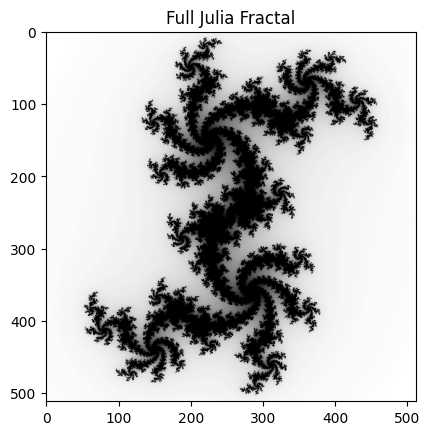

In [2]:
size = 512

full_julia_image = julia.Julia_shader_info.generate_image(
    width=size, height=size,
    frag_uniforms={
    'u_position': [-1.2, -1.2],  # Bottom left corner
    'u_dimension': [2.4, 2.4],   # Width, height
    'u_constant': [-0.37, -0.36],
    'u_color_wave': -1
})

full_julia_np = np.array(full_julia_image.convert('L'))

# full_julia_image = mpimg.imread(r'shaders/julia/data/julia_4096.png')
fig, ax = plt.subplots()
ax.imshow(full_julia_np, cmap='gray', extent=[-1.2, 1.2, -1.2, 1.2])
ax.set_title('Full Julia Fractal')
plt.show()

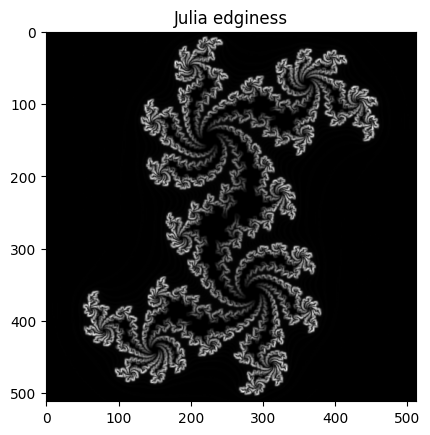

In [3]:
julia_edges = shader_data_loaders.edginess(full_julia_np)
fig, ax = plt.subplots()
ax.imshow(julia_edges, cmap='gray')
ax.set_title('Julia edginess')
plt.show()

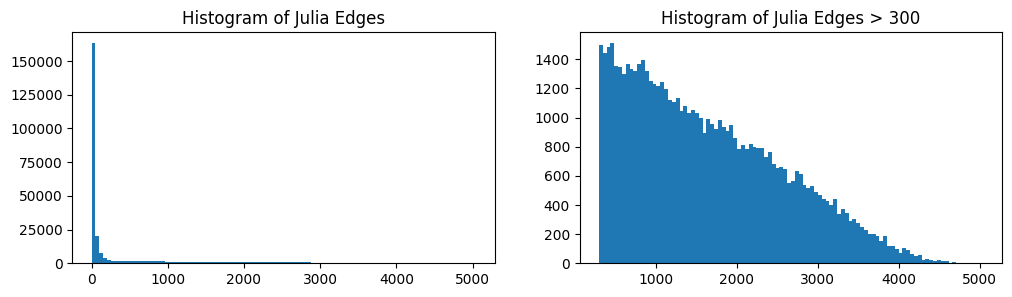

In [4]:
julia_edges_values = julia_edges.reshape(-1)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3))
ax[0].hist(julia_edges_values, bins=100)
ax[0].set_title('Histogram of Julia Edges')

edginess = 300
ax[1].hist(julia_edges_values[julia_edges_values>edginess], bins=100)
ax[1].set_title(f'Histogram of Julia Edges > {edginess}')
plt.show()

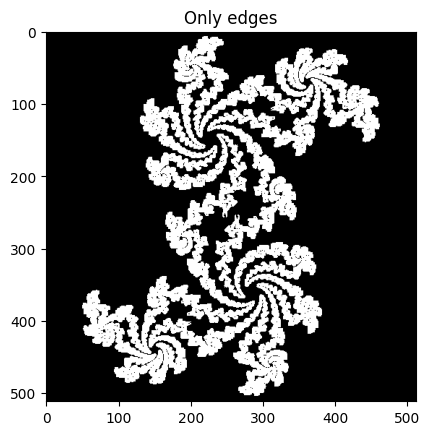

In [5]:
fig, ax = plt.subplots()
ax.imshow(julia_edges>edginess, cmap='gray')
ax.set_title('Only edges')
plt.show()

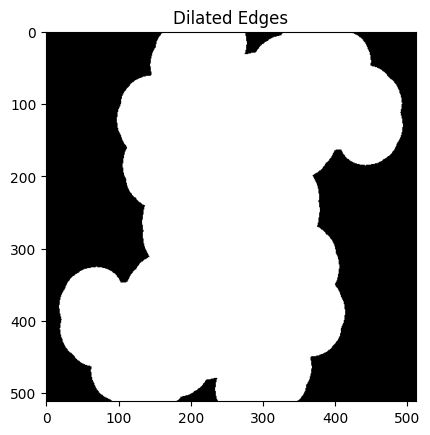

In [6]:
# `mask` is a boolean NumPy array
mask = julia_edges > edginess
radius = 64
mask = binary_dilation(mask, structure=disk(radius//2))

fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')
ax.set_title('Dilated Edges')
plt.show()

In [7]:
mask[:radius, :]  = False
mask[-radius:, :] = False
mask[:, radius]   = False
mask[:, -radius:] = False

dataset = shader_data_loaders.PositionCropDataset(
    image=full_julia_np,
    positions=np.argwhere(mask)[:,[1,0]],  # switch from (y,x) coordinate to (x,y),
    diameter = radius * 2,
    bounding_box=((-1.2, 1.2), (-1.2, 1.2)),
    transform=torchvision.transforms.ToTensor()
)

Let's put all of this in a single place:

In [8]:
def edge_dataset(image_np: np.ndarray, radius: int, edginess: float = 1, bounding_box: Optional[Tuple[Tuple[float, float], Tuple[float, float]]] = None):
    image_edginess = shader_data_loaders.edginess(image_np)

    mask = image_edginess > edginess
    mask = binary_dilation(mask, structure=disk(radius//2))
    mask[:radius, :]  = False
    mask[-radius:, :] = False
    mask[:, radius]   = False
    mask[:, -radius:] = False

    return shader_data_loaders.PositionCropDataset(
        image=image_np,
        positions=np.argwhere(mask)[:,[1,0]],  # switch from (y,x) coordinate to (x,y),
        diameter = radius * 2,
        bounding_box=bounding_box,
        transform=torchvision.transforms.ToTensor()
    )

julia_dataset = edge_dataset(full_julia_np, radius, edginess, ((-1.2, 1.2), (-1.2, 1.2)))
print(f'Generated dataset of size {len(julia_dataset)}')

Generated dataset of size 122761


In [9]:
def random_subdataset(dataset: torch.utils.data.Dataset, size:int):
    subset_size = min(len(dataset), size)
    indices = random.sample(range(len(dataset)), subset_size)
    return torch.utils.data.Subset(dataset, indices)

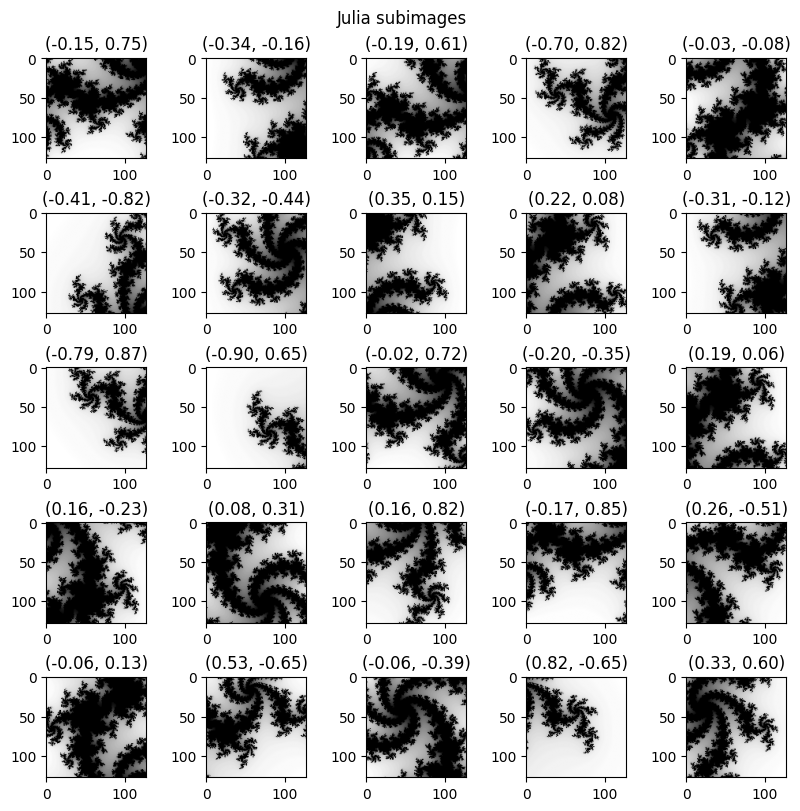

In [10]:
fig, axes = plt.subplots(5,5, figsize=(8,8), constrained_layout=True)
fig.suptitle('Julia subimages')

set_seed(0)
indices = random.sample(range(len(dataset)), 25)
for i, ax in zip(indices, axes.reshape(-1)):
    ax.imshow(julia_dataset[i][0].squeeze(0).numpy(), cmap='gray')

    v = julia_dataset[i][1]
    formatted_title = f"({v[0]:.2f}, {v[1]:.2f})"
    ax.set_title(formatted_title)
plt.show()

# Pretraining

In [11]:
device = model_tester.get_device()
image_channels, image_size, _ = julia_dataset[0][0].shape
output_dim = julia_dataset[0][1].shape[0]

set_seed(0)

model = vision_transformer.VisionTransformer(
    image_size = image_size, image_channels = image_channels,
    patch_size = 8, emb_dim = 16, output_dim = output_dim
)
model.final_layer[1].bias.data.zero_()
model.to(device)
model.update_init_state()
model

VisionTransformer(
  (patcher): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
  (linearizer): Linear(in_features=64, out_features=16, bias=True)
  (transformer): Transformer(
    (attention_step): ResidualAdd(
      (fn): Sequential(
        (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (1): Attention(
          (key): Linear(in_features=16, out_features=16, bias=True)
          (query): Linear(in_features=16, out_features=16, bias=True)
          (value): Linear(in_features=16, out_features=16, bias=True)
        )
      )
    )
    (feed_forward_step): ResidualAdd(
      (fn): Sequential(
        (0): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=16, out_features=16, bias=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.0, inplace=False)
        (4): Linear(in_features=16, out_features=16, bias=True)
        (5): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (positional_embedding): Li

Now that we have both the dataset and a model we can compare the number of parameters in the model and the size of the dataset.
Outside the topology of the model, there are 2 main parameters affecting the ratio between these two quantities - the size $L$ of the original image and the radius $R$ of the subimages.
- The dataset is comprised of subimages around the boundary of the fractal. While the boundary is more or less a 1D curve, if it twists and turns enough, these subimages will cover a large portion of the original image. Counting their centers, even when avoiding the boundary of the image itself, it is the order of magnitude of $(L-2R)^2$.
- On the other hand, the size $L$ doesn't affect the model at all, since it only sees the subimages. It does however depend more or less quadratically on the size $R$.

This means that if we want the dataset to be large enough compared to the number of parameters, we would want $L$ to be large compared to $R$. **However**, increasing the ratio $L/R$ means that the subimages are smaller compared to the large image, which at least intuitively seems to make the task of finding their position harder.

In any case, for our case we have:

In [12]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Image size = {size}, Radius = {radius}')
print(f'Trainable parameters: {trainable_params}')
print(f'Dataset size: {len(julia_dataset)}  ( (L-2R)^2 = {(size-2*radius)**2} )')

Image size = 512, Radius = 64
Trainable parameters: 6642
Dataset size: 122761  ( (L-2R)^2 = 147456 )


Before we even train the model, let's see where we are starting, by computing the initial predictions and their errors for our randomly initialized model.
For that we choose a random sample of 10000 subimages, and run the model on each one.

In [13]:
set_seed(0)
init_dataset = random_subdataset(julia_dataset, 10000)

def per_sample_evaluation(model, data_loader):

    # Collect all values, predictions, errors, and input images
    all_values = []
    all_predictions = []
    all_images = []

    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)

            all_images.append(x_batch.cpu())
            all_values.append(y_batch.cpu().numpy())
            all_predictions.append(output.cpu().numpy())

    all_values = np.concatenate(all_values, axis=0)                # shape (N, 2)
    all_predictions = np.concatenate(all_predictions, axis=0)      # shape (N, 2)
    all_errors = ((all_values-all_predictions)**2).sum(axis=1)     # shape (N,)
    all_images = torch.cat(all_images, dim=0)                      # shape (N, C, H, W)

    return all_images, all_values, all_predictions, all_errors

all_images, all_values, all_predictions, all_errors = per_sample_evaluation(model, DataLoader(init_dataset, batch_size=32, shuffle=False))

We use two plots to get some intuition:
1. The histogram of the distances between the actual center of the subimage and the model's prediction,
2. A scatter of all the centers.

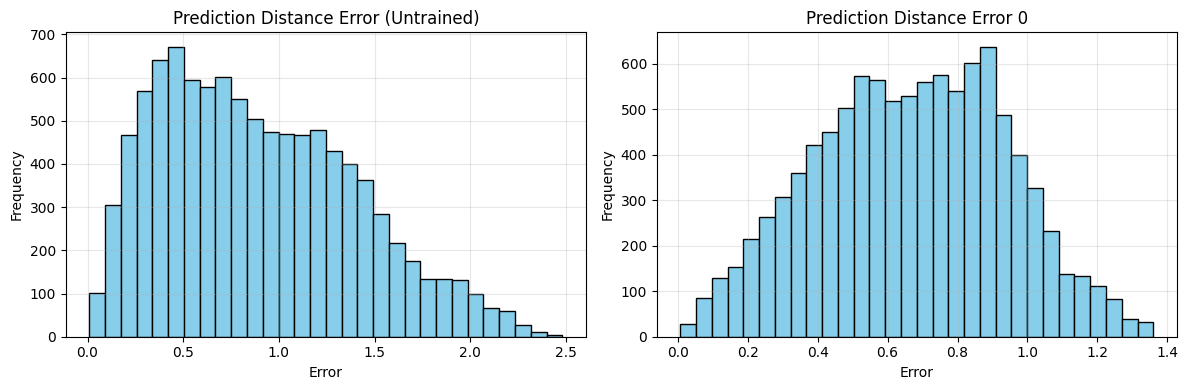

In [14]:
all_errors0 = (all_values**2).sum(axis=1)

def plot_distance_histogram(ax, values_squared, title: str, bins: int = 30):
    ax.hist(np.sqrt(values_squared), bins=bins, color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Error")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

plot_distance_histogram(axs[0], all_errors, title='Prediction Distance Error (Untrained)')
plot_distance_histogram(axs[1], all_errors0, title='Prediction Distance Error 0')

fig.tight_layout()
plt.show()


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


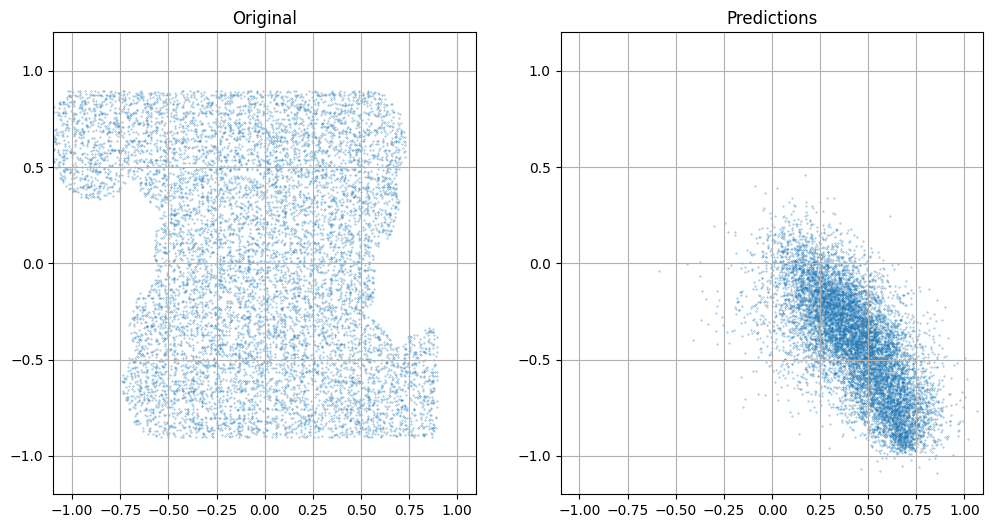

In [15]:
def scatter(title:str, points, ax):
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s = 0.1)
    ax.set_title(title)
    ax.grid(True)
    ax.axis('equal')  # Ensures x and y are on the same scale
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
scatter('Original', all_values, axs[0])
scatter('Predictions', all_predictions, axs[1])
plt.show()

As can be seen, the subimages centers, and their predictions are scattered more or less in the square $[-1,1] \times [-1,1]$, and since the model is untrained, the average distance has order of magnitude $1$.

# First training session


Let's see if and how much a single training session improves this, where we run it on a dataset of size 10 times the number of parameters:

In [16]:
set_seed(0)
dataset = random_subdataset(julia_dataset, 10*trainable_params)
train_dataset, dev_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=[0.8, 0.1, 0.1])

# On MPS don't use batch_size >= 128
train_loader=DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader=DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# For reproducibility:
model.initialize_state()
set_seed(0)

model_tester.train_model(
    model = model,
    parameters = model_tester.TrainingParameters(
        epochs = 10,
        learning_rate = 0.001
    ),
    data_loader = train_loader, train_size = len(train_dataset),
    loss_function = nn.MSELoss())

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/10], Average Loss: 0.1605
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/10], Average Loss: 0.1025
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/10], Average Loss: 0.0676
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/10], Average Loss: 0.0434
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [5/10], Average Loss: 0.0253
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [6/10], Average Loss: 0.0176
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch 

Note that the Mean Squared Error loss `MSE` computed above, is not just the distance squared, but also divided by 2, since there are 2 coordinates. This means that the average distance error at the end is roughly $\sqrt{2*x}$.

Replotting the histogram and scatter from before, we get:

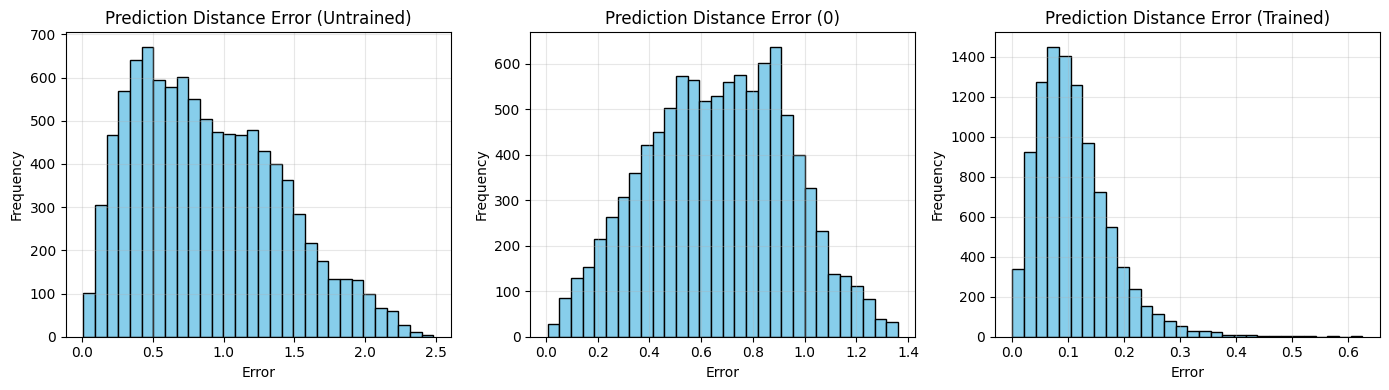

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


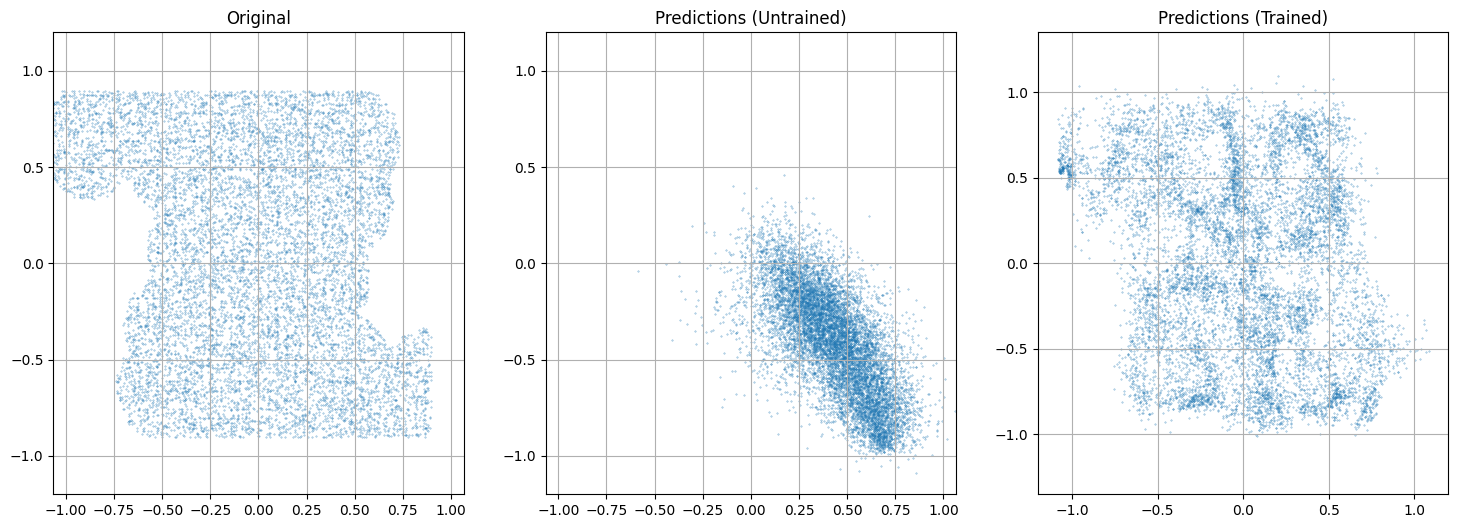

In [18]:
_, _, trained_all_predictions, trained_all_errors = per_sample_evaluation(model, DataLoader(init_dataset, batch_size=32, shuffle=False))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

plot_distance_histogram(axs[0], all_errors, title='Prediction Distance Error (Untrained)')
plot_distance_histogram(axs[1], all_errors0, title='Prediction Distance Error (0)')
plot_distance_histogram(axs[2], trained_all_errors, title='Prediction Distance Error (Trained)')

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
scatter('Original', all_values, axs[0])
scatter('Predictions (Untrained)', all_predictions, axs[1])
scatter('Predictions (Trained)', trained_all_predictions, axs[2])
plt.show()

We already see that the error in distance is much better than untrained model. Also, the points scatter resemblance more the original scatter.

It can also be interesting to know which of the original center point have good approximations, which can be seen in the following plot:

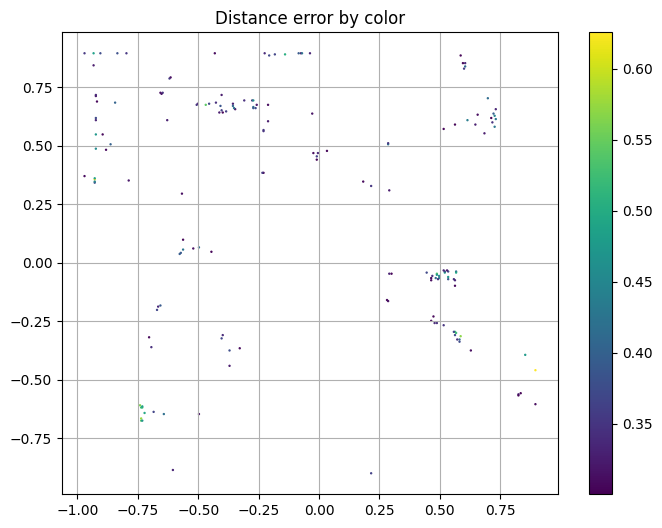

In [19]:
plt.figure(figsize=(8, 6))

cutoff = 0.2**2
plus_mask = trained_all_errors > cutoff
minus_mask = trained_all_errors <= cutoff
mask = plus_mask

sc = plt.scatter(all_values[mask][:, 0], all_values[mask][:, 1], c=np.sqrt(trained_all_errors[mask]), cmap='viridis', s=0.5)
plt.colorbar(sc)
plt.title('Distance error by color')
plt.grid(True)
plt.show()

Another way to analyse the learning, is to view these points directly on our fractal and see where they are mapped onto:

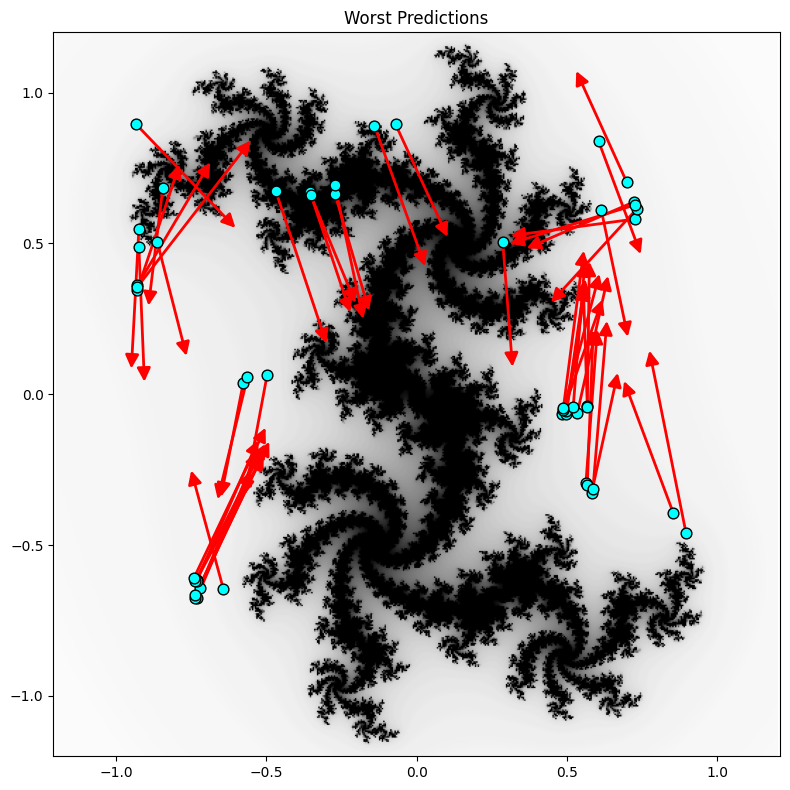

In [20]:
from matplotlib.patches import FancyArrowPatch

worst_indices = np.argsort(trained_all_errors)[-50:]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(
    full_julia_image,
    cmap='gray',
    extent=[-1.2, 1.2, -1.2, 1.2],
    origin='lower'
)

# Extract the ground truth and predictions for those indices
worst_gt = all_values[worst_indices]       # shape (10, 2)
worst_pred = trained_all_predictions[worst_indices]  # shape (10, 2)

for gt, pred in zip(worst_gt, worst_pred):
    # print(f'{gt}->{pred}')
    arrow = FancyArrowPatch(gt, pred, mutation_scale=20, arrowstyle='-|>', color='red', linewidth=2)
    ax.add_patch(arrow)

    ax.scatter(gt[0], gt[1], color='cyan', edgecolor='black', s=60, zorder=3, label='Ground Truth')
    # ax.scatter(pred[0], pred[1], color='red', edgecolor='black', s=60, zorder=4, label='Prediction')

ax.set_title('Worst Predictions')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.axis('equal')
ax.grid(False)

plt.tight_layout()
plt.show()

We see that point near the origin have smaller distance error, though this is because most of the predictions are near the origin, so automatically the error there will be smaller. However, it does seems that along the $X$-axis the predictions are better than along the $Y$-axis.



Finally, before we look to improve the learning process, let's check if it over fits:

In [21]:

train_loss = model_tester.test_model(
    model = model,
    test_loader = train_loader,
    loss_function = nn.MSELoss()
)
print(f'train loss is {train_loss.item()}')


test_loss = model_tester.test_model(
    model = model,
    test_loader = test_loader,
    loss_function = nn.MSELoss()
)
print(f'test loss is {test_loss.item()}')

train loss is 0.00830405205488205
test loss is 0.00876433216035366


The train and test loss are similar, indicating that we probably don't overfit the training data.

# Improving the learning process

In [22]:
learning_rates_log = np.arange(10)
learning_rates = np.power(0.1, learning_rates_log)
train_losses = []

print(f'Learning rates are {learning_rates}')

for lr in learning_rates:
    print(f'\nlearning rate is {lr:.2e}')
    model.initialize_state()
    set_seed(0)

    model_tester.train_model(
        model = model,
        parameters = model_tester.TrainingParameters(
            epochs = 4,
            learning_rate = lr
        ),
        data_loader = train_loader, train_size = len(train_dataset),
        loss_function = nn.MSELoss())

    train_loss = model_tester.test_model(
        model = model,
        test_loader = train_loader,
        loss_function = nn.MSELoss()
    )
    print(f'Final train loss is {train_loss.item()}')
    train_losses.append(train_loss.item())

Learning rates are [1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]

learning rate is 1.00e+00
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/4], Average Loss: 1.8581
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [2/4], Average Loss: 0.2313
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [3/4], Average Loss: 0.2227
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [4/4], Average Loss: 178.2138
train_model took 59.384133100509644 seconds
Final train loss is 1933.6197509765625

learning rate is 1.00e-01
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
Epoch [1/4], Average Loss: 0.2641
 |██████████████████████████████████████

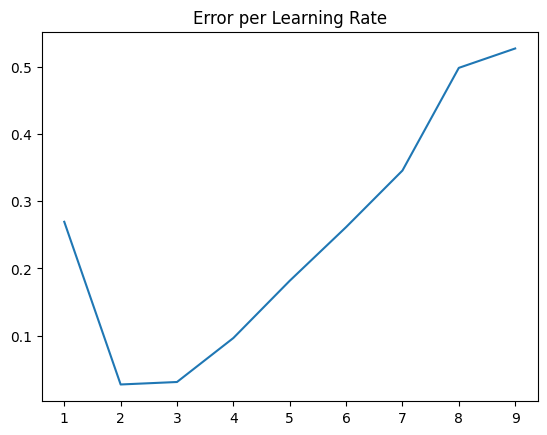

In [25]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots()
ax.set_title('Error per Learning Rate')
ax.plot(learning_rates_log[1:], train_losses[1:])
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()

This actually shows that the $0.001=10^{-3}$ from the previous section was a good choice for the learning rate.

# Looking for symmetries